# Spin-polarized calculations with BigDFT

The goal of this notebook is to explain how to do a spin-polarized calculation with BigDFT (`nspin=2`).
We start with the molecule O$_2$ and a non-spin polarized calculation, which is the code default.
To do that we only have to specify the atomic positions of the molecule.

In [1]:
from BigDFT import Calculators as C
calc = C.SystemCalculator()
posO1=3*[0.0]
posO2=[0.0, 0.0, 1.2075] # in angstroem
inpt={'posinp': 
      { 'positions': [ {'O': posO1 }, {'O': posO2 }], 'units': 'angstroem' }}
logNSP = calc.run(input=inpt)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft
Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft


Such calculation produced a converged set of KS LDA orbitals, with the following density of states:

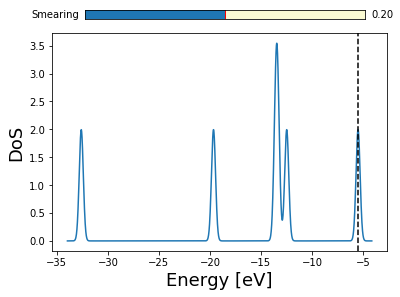

In [2]:
%matplotlib inline
DoS=logNSP.get_dos(label='NSP')
DoS.plot()

Now we do the same calculation but with spin-polarized specifying `nspin=2`, in the `dft` field.

In [3]:
inpt['dft']={'nspin': 2}
logSP = calc.run(input=inpt)

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft


We may see that this run did not produce any difference with respect to the previous one. Even though we doubled the number of orbitals, the input guess wavefunctions and densities are identical in both the spin sectors. As a consequence the energy and the DoS are identical to the NSP case:

-31.8014240962151 -31.801424096215143


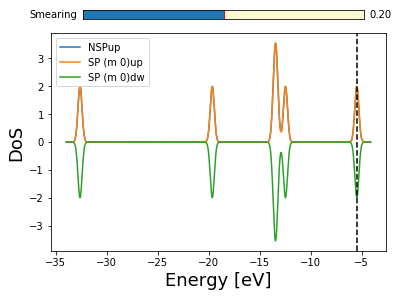

In [5]:
print (logNSP.energy,logSP.energy)
DoS.append_from_bandarray(logSP.evals,label='SP (m 0)')
DoS.plot()

This is due to the fact that:
 1. We had the same input guess for up and down subspaces;
 2. We had the same number of orbitals in both the sectors and no empty orbitals during the minimization.
 
Such problems can be solved at the same time by performing mixing scheme with *random* initialization of the wavefunctions:

In [6]:
inpt['import']='mixing'
inpt['mix']={'iscf': 12, 'itrpmax': 20} # mixing on the potential, just 20 Hamiltonian iterations for a quick look
inpt['dft']['inputpsiid']= 'RANDOM' #for random initialization
logSP_mix = calc.run(input=inpt)

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft


We see that with these input parameters the DoS is different from the NSP case, the energy is lower and the net polarization is 2:

-31.8014240962151 -31.862696759999135


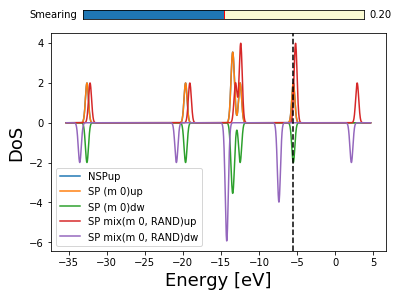

Magnetic Polarization -2.0


In [9]:
print (logNSP.energy,logSP_mix.energy)
DoS.append_from_bandarray(logSP_mix.evals,label='SP mix(m 0, RAND)')
DoS.plot()
print ('Magnetic Polarization', logSP_mix.magnetization)

We see that to break the symmetry it is therefore necessary to have different IG subspaces between up and down orbitals, otherwise the results will be identical to the NSP case.
Now that we know the polarization of the molecule, we may perform a direct minimization calculation of the molecule by specifying from the beginning the `mpol: 2` condition. We can also add some empty orbitals using the keyword `norbsempty`.

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft
-31.862696759999135 -31.863446490458415


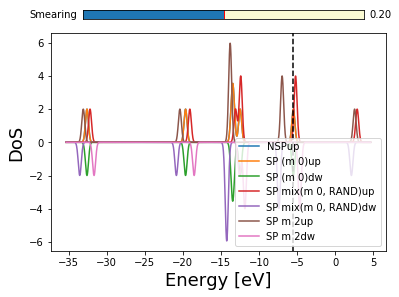

In [11]:
inpt={'dft': { 'nspin': 2, 'mpol': 2},
      'mix': { 'norbsempty': 2 },
      'posinp': 
      { 'positions': [ {'O': posO1 }, {'O': posO2 }], 'units': 'angstroem' } }
logSP_m2 = calc.run(input=inpt)
print (logSP_mix.energy,logSP_m2.energy)

DoS.append_from_bandarray(logSP_m2.evals,label='SP m 2')
DoS.plot()

We show that the total magnetization is 2 in the case of the oxygen dimer. The DoS is not exactly the same because the mixing scheme was not fully converged (check increasing the value of `itrpmax`).

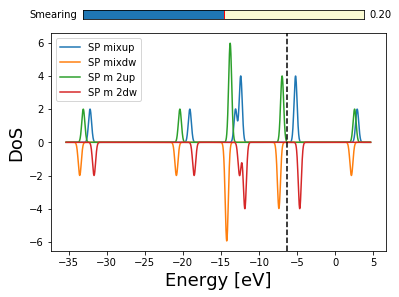

In [12]:
DoS=logSP_mix.get_dos(label='SP mix')
DoS.append_from_bandarray(logSP_m2.evals,label='SP m 2')
DoS.plot()

## Odd electron system: the N atom
What does happen when the number of electrons is odd as in the case of N?
If we do a NSP calculation, the occupation of the last state is 1. Switching only the parameter `nspin` to the value 2, we do the same calculation with averaged-occupation (0.5 for the last up and down state).

To do a spin-polarisation calculation, we need to change mpol which is the difference between the number of occupied electrons of different spins.
In the same way, we can look for the total magnetization using the mixing scheme.

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft
Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft
-9.594850332910859 -9.594849656308849
-0.2409543690293 -0.2409528585367


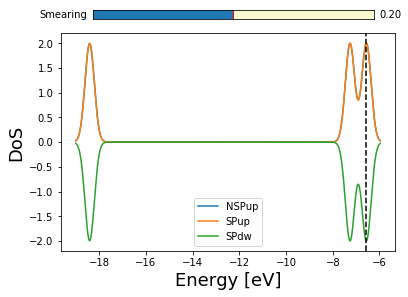

In [14]:
inpt = { 'dft': { 'nspin': 1}, 
         'posinp': { 'units': 'angstroem', 
                     'positions':  [ {'N': 3*[0.0] } ] } }
logNSP = calc.run(input=inpt)

inpt['dft']['nspin'] = 2
logSP = calc.run(input=inpt)

print (logNSP.energy,logSP.energy)
print (logNSP.fermi_level,logSP.fermi_level)
DoS=logNSP.get_dos(label='NSP')
DoS.append_from_bandarray(logSP.evals,label='SP')
DoS.plot()

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1883596 /home/wdawson/share/binaries/python3/install/bin/bigdft
3.0


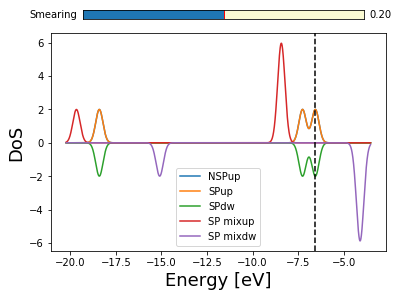

In [16]:
inpt['dft']['inputpsiid']='RANDOM' #Random input guess
inpt['mix']={'iscf': 12, 'itrpmax': 30} # mixing on the potential, just 30 Hamiltonian iterations for a quick look
inpt['import'] = 'mixing'
logSP_mix = calc.run(input=inpt)
print (logSP_mix.magnetization)

DoS.append_from_bandarray(logSP_mix.evals,label='SP mix')
DoS.plot()

We found a total magnetization of 3 following the Hund's rule.

## Defining the input guess (*ig_occupation* keyword)
We have shown that by default, the input guess is LCAO (localised atomic orbitals) defining by the pseudo-orbitals.
The occupation is sphere symmetry (same occupation per orbital moment).
We have used random input guess to break the spin symmetry.
We can also use an LCAO input guess and indicate the occupation number for the input guess using the keyword `ig_occupation` in order to break the spin symmetry

Creating the yaml input file "input.yaml"
Executing command:  mpirun -np 2 /local/deutsch/Forge/BigDFT/build-mpif90-openmp/install/bin/bigdft
-9.74145176349 -9.74158042631


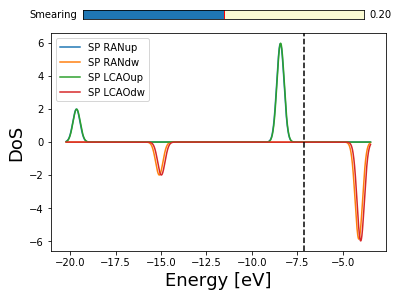

In [11]:
inpt['dft']['inputpsiid']='LCAO' #LCAO input guess
inpt['ig_occupation'] = { 'N': { '2s': { 'up': 1, 'down': 1}, '2p': {'up': [1,1,1], 'down': 0} } }
logLCAO_mix = calc.run(input=inpt)
print logSP_mix.energy,logLCAO_mix.energy

DoS=logSP_mix.get_dos(label='SP RAN')
DoS.append_from_bandarray(logLCAO_mix.evals,label='SP LCAO')
DoS.plot()

Instead of `ig_occupation`, it is also possible to specify the keyword `IGSpin` per atom in the `posinp` dictionary.

Creating the yaml input file "input.yaml"
Executing command:  mpirun -np 2 /local/deutsch/Forge/BigDFT/build-mpif90-openmp/install/bin/bigdft
-9.74145176349 -9.74158042631 -9.74158042096


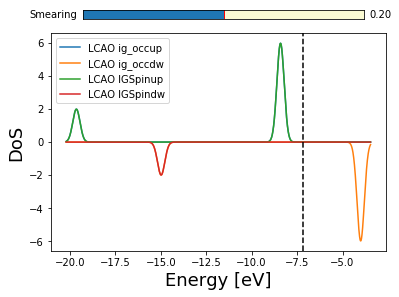

In [12]:
inpt = { 'dft': { 'nspin': 2, 'mpol': 3}, 
         'posinp': { 'units': 'angstroem', 
                     'positions':  [ {'N': 3*[0.0], 'IGSpin': 3 } ] },
         'ig_occupation': { 'N': { '2s': { 'up': 1, 'down': 1}, 
                                   '2p': { 'up': [1,1,1], 'down': 0} } } }

logIG = calc.run(input=inpt)
print logSP_mix.energy,logLCAO_mix.energy,logIG.energy

DoS=logLCAO_mix.get_dos(label='LCAO ig_occ')
DoS.append_from_bandarray(logIG.evals,label='LCAO IGSpin')
DoS.plot()

## Occupation numbers
Finally, it is possible to set the occupation numbers for each state by the parameter `occup`.
In this case, the direct minimization is done with this occupation number.
In the case of N, there are 8 orbitals, the first 4 are up and the other ones down.
Here we do a calculation following the Hund's rule.

Creating the yaml input file "input.yaml"
Executing command:  mpirun -np 2 /local/deutsch/Forge/BigDFT/build-mpif90-openmp/install/bin/bigdft
-9.74145176349 -9.74158042631 -9.74158042096 -9.7415803697


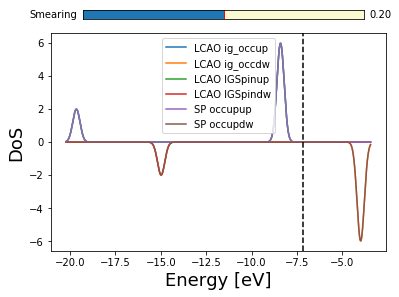

In [13]:
del inpt['ig_occupation']
inpt['occupation'] = { 'up':   { 'Orbital 1': 1, 'Orbital 2': 1, 'Orbital 3': 1, 'Orbital 4': 1 },  # up
                       'down': { 'Orbital 1': 1, 'Orbital 2': 0, 'Orbital 3': 0, 'Orbital 4': 0 } }# down
logS = calc.run(input=inpt)
print logSP_mix.energy,logLCAO_mix.energy,logIG.energy,logS.energy

DoS.append_from_bandarray(logS.evals,label='SP occup')
DoS.plot()